In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

from matplotlib.path import Path
%matplotlib inline

from visualization_utilities import *
from learning_utilities import *
from sift_spm_utilities import *

Setting environment for Gordon


Cannot import mxnet.


In [2]:
sift_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_SIFT_SPM_features'

In [3]:
# map between structure names and classifier labels

names0 = sorted(list(set(labels_unsided + ['bg']) - {'outerContour'}))
names = names0 + [name + '_surround' for name in names0 if name != 'bg']
name_to_label = dict(zip(names, range(len(names))))
label_to_name = {label: name for name, label in name_to_label.iteritems()}
name_to_color = dict(zip(name_to_label.keys(), random_colors(len(name_to_label))))

In [127]:
# train_data, train_labels, train_addresses = load_spm_histograms_train('MD589', names=set(names0), 
#                                                                       name_to_label=name_to_label, 
#                                                                     n_sample_per_class=1000, use_level0_only=True)

train_data, train_labels, train_addresses = load_spm_histograms_train('MD589', names={'Amb', 'AP'}, 
                                                                      name_to_label=name_to_label, 
                                                                    n_sample_per_class=1000, use_level0_only=True)

# random_indices = np.random.choice(range(train_data.shape[0]), 100, replace=False)
# train_data = train_data[random_indices]
# train_labels = train_labels[random_indices]
# train_addresses = [train_addresses[i] for i in random_indices]

n_train = train_data.shape[0]
print n_train, 'training data'

train_data_normalized = train_data / train_data.sum(axis=1)[:,None].astype(np.float)

379 training data


In [ ]:
# random_addresses = [train_addresses[i] for i in np.where(train_labels==name_to_label['LC'])[0]][::10]

random_addresses = [train_addresses[i] for i in np.random.randint(0, n_train, 30)]
print random_addresses

patches = extract_patches_given_addresses(random_addresses[:5])
display_images_in_grids(patches, nc=5, titles=[(stack,sec,name,i) for stack, sec, name, i in random_addresses[:5]])

In [ ]:
export_images_given_patch_addresses(random_addresses, downscale_factor=8,
                                    fn_template='/home/yuncong/csd395/CSHL_data_patches/viz/%(stack)s_%(sec)04d_train.jpg',
                                   name_to_color=name_to_color)

In [128]:
f, l = section_range_lookup['MD594']
# test_data, test_labels, test_addresses = load_spm_histograms_train('MD594', names=set(names0), 
#                                                                    name_to_label=name_to_label, 
#                                                                    use_level0_only=True,
#                                                                   secs=range(f, l+1, 5))

test_data, test_labels, test_addresses = load_spm_histograms_train('MD594', names={'Amb', 'AP'},
                                                                   name_to_label=name_to_label, 
                                                                   use_level0_only=True,
                                                                  secs=range(f, l+1, 5))

n_test = test_data.shape[0]
print n_test, 'test data'

# test_data, test_addresses = load_spm_histograms('MD594', 'roi1', n_sample_per_sec=1000, use_level0_only=True)
# print test_data.shape[0], 'test data'

test_data_normalized = test_data / test_data.sum(axis=1)[:,None].astype(np.float)

392 test data


In [168]:
train_dist_mat = bp.unpack_ndarray_file(sift_dir + '/train/train_spm_dist_mat.bp')

train_data = bp.unpack_ndarray_file(sift_dir + '/train/train_data.bp')
train_labels = bp.unpack_ndarray_file(sift_dir + '/train/train_labels.bp')
train_addresses = pickle.load(open(sift_dir + '/train/train_address.pkl', 'r'))

n_train = train_data.shape[0]
print n_train, 'training data'
train_data_normalized = train_data / train_data.sum(axis=1)[:,None].astype(np.float)

test_data = bp.unpack_ndarray_file(sift_dir + '/test/test_data.bp')
test_labels = bp.unpack_ndarray_file(sift_dir + '/test/test_labels.bp')
test_addresses = pickle.load(open(sift_dir + '/test/test_address.pkl', 'r'))

n_test = test_data.shape[0]
print n_test, 'test data'
test_data_normalized = test_data / test_data.sum(axis=1)[:,None].astype(np.float)

10785 training data
10088 test data


In [169]:
label_to_clf = {l: i for i, l in enumerate(sorted(np.unique(train_labels)))}
clf_to_label = dict(enumerate(sorted(np.unique(train_labels))))
train_labels_clf = np.array([label_to_clf[i] for i in train_labels])
test_labels_clf = np.array([label_to_clf[i] for i in test_labels])

n_classes = len(label_to_clf)

In [195]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.cross_validation import cross_val_score

In [232]:
n_iter = 200

In [233]:
train_accuracy_evolution = np.zeros((n_iter, ))
test_accuracy_evolution = np.zeros((n_iter, ))

In [ ]:
n_estimator = n_iter
max_depth = 6
    
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth), 
                         n_estimators=n_estimator, learning_rate=1.0, algorithm='SAMME')
#     clf = RandomForestClassifier(n_estimators=n_estimator, max_depth=None)
#     clf = ExtraTreesClassifier(n_estimators=n_estimator, max_depth=None)
#     clf = OneVsRestClassifier(LinearSVC())

t = time.time()
clf.fit(train_data_normalized, train_labels)
print time.time() - t, 'sec'

label_to_clf = {l: i for i, l in enumerate(clf.classes_)}

for it, train_probs in enumerate(clf.staged_predict_proba(train_data_normalized)):
#         train_probs = clf.predict_proba(train_data_normalized)
    predicted_train_labels = np.argmax(train_probs, axis=1)
#     predicted_train_labels = clf.predict(train_data_normalized)
    train_labels_clf = np.array([label_to_clf[i] for i in train_labels])
    train_acc = np.count_nonzero(predicted_train_labels == train_labels_clf) / float(len(train_labels))
    train_accuracy_evolution[it] = train_acc

for it, test_probs in enumerate(clf.staged_predict_proba(test_data_normalized)):
#         train_probs = clf.predict_proba(train_data_normalized)
    predicted_test_labels = np.argmax(test_probs, axis=1)
#     predicted_train_labels = clf.predict(train_data_normalized)
    test_labels_clf = np.array([label_to_clf[i] for i in test_labels])
    test_acc = np.count_nonzero(predicted_test_labels == test_labels_clf) / float(len(test_labels))
    test_accuracy_evolution[it] = test_acc

#     print cross_val_score(clf, train_data_normalized, train_labels_clf).mean()

149.548691988 sec


final training accuracy 0.87575336115
final test accuracy 0.369250594766


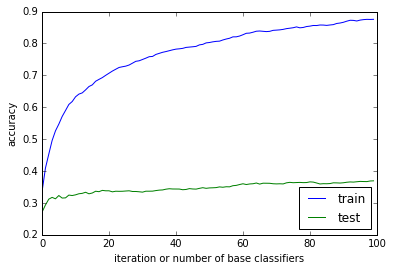

In [230]:
plt.plot(train_accuracy_evolution, label='train');
plt.plot(test_accuracy_evolution, label='test');
plt.xlabel('iteration or number of base classifiers');
plt.ylabel('accuracy');
plt.legend(loc='lower right');

print 'final training accuracy', train_accuracy_evolution[-1]
print 'final test accuracy', test_accuracy_evolution[-1]

In [198]:
clf_to_label = dict(enumerate(clf.classes_))
label_to_clf = {l: i for i, l in clf_to_label.iteritems()}
train_labels_clf = np.array([label_to_clf[i] for i in train_labels])
test_labels_clf = np.array([label_to_clf[i] for i in test_labels])

n_classes = len(label_to_clf)

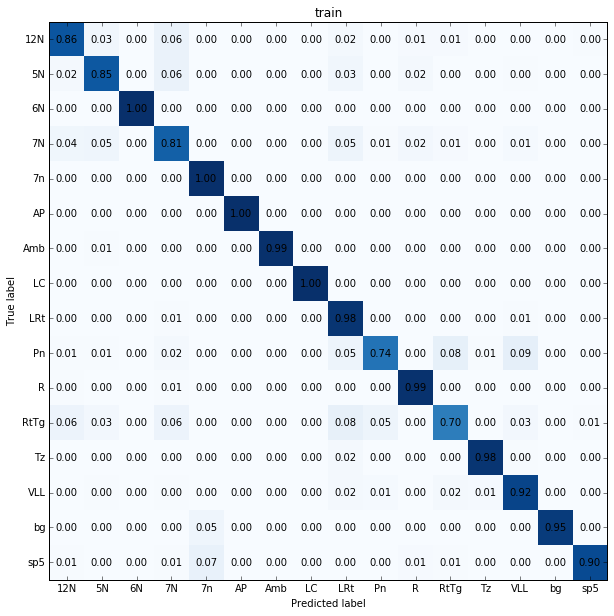

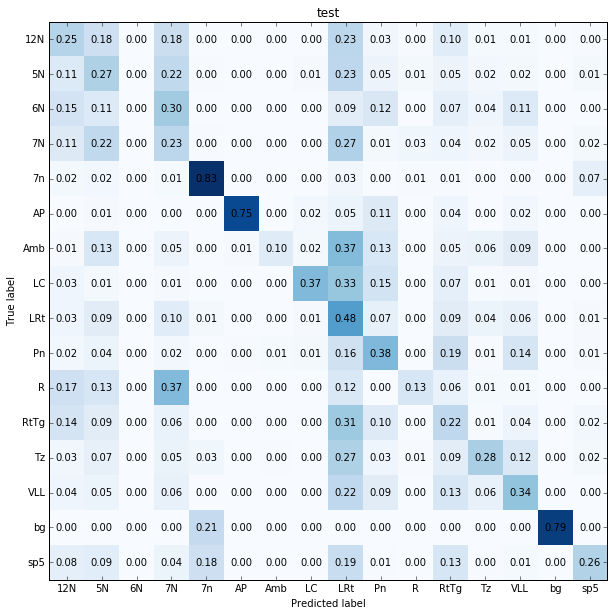

In [200]:
M_train = compute_confusion_matrix(predicted_train_labels, train_labels_clf)
plot_confusion_matrix(M_train, labels=[label_to_name[clf_to_label[i]] for i in range(n_classes)], title='train', figsize=(10,10))

M_test = compute_confusion_matrix(predicted_test_labels, test_labels_clf)
plot_confusion_matrix(M_test, labels=[label_to_name[clf_to_label[i]] for i in range(n_classes)], title='test', figsize=(10,10))

In [ ]:
# method 1
t = time.time()

def compute_intersection_kernel_oneJob(i, j1):
#     dist = .5 * np.sum(train_data_normalized + h - np.abs(train_data_normalized - h), axis=1)
    dist = np.minimum(train_data_normalized[i], train_data_normalized[j1:]).sum(axis=1)
    return dist

train_dist_triangle = np.concatenate(Parallel(n_jobs=8)(delayed(compute_intersection_kernel_oneJob)(i, i) 
                                     for i in range(n_train)))

sys.stderr.write('compute intersection kernel: %f seconds\n' % (time.time() - t)) # ~ 200s / 12k training data

train_dist_mat = np.empty((n_train, n_train))
train_dist_mat[np.triu_indices(n_train)] = train_dist_triangle
r = np.tril_indices(n_train)
train_dist_mat[r] = train_dist_mat.T[r]

In [ ]:
# method 2
t = time.time()

def compute_intersection_kernel_oneJob(h):
#     dist = .5 * np.sum(train_data_normalized + h - np.abs(train_data_normalized - h), axis=1)
    dist = np.minimum(train_data_normalized, h).sum(axis=1)
    return dist

# train_dist_mat = np.array(Parallel(n_jobs=16)(delayed(compute_intersection_kernel_oneJob)(h) 
#                                      for h in train_data_normalized[:1000]))

sys.stderr.write('compute intersection kernel: %f seconds\n' % (time.time() - t)) # ~ 400s / 12k training data

In [130]:
# method 3
t = time.time()

def compute_intersection_kernel_oneJob(i, ni, j, nj):
    scores = np.minimum(train_data_normalized[i:i+ni, None], train_data_normalized[j:j+nj]).sum(axis=-1)
    return scores

train_score_mat = np.empty((n_train, n_train))
ni = 100
nj = 100
for j in range(0, n_train, nj):
    train_score_mat[:, j:j+nj] = np.concatenate(Parallel(n_jobs=16)(delayed(compute_intersection_kernel_oneJob)(i, ni, j, nj) 
                                                    for i in range(0, n_train, ni)))

sys.stderr.write('compute intersection kernel: %f seconds\n' % (time.time() - t)) # ~ 400s / 12k training data

train_dist_mat = 1. - train_score_mat

compute intersection kernel: 2.011994 seconds


In [48]:
bp.pack_ndarray_file(train_dist_mat, sift_dir + '/train/train_spm_dist_mat.bp')

bp.pack_ndarray_file(train_data, sift_dir + '/train/train_data.bp')
bp.pack_ndarray_file(train_labels, sift_dir + '/train/train_labels.bp')
pickle.dump(train_addresses, open(sift_dir + '/train/train_address.pkl', 'w'))

bp.pack_ndarray_file(test_data, sift_dir + '/test/test_data.bp')
bp.pack_ndarray_file(test_labels, sift_dir + '/test/test_labels.bp')
pickle.dump(test_addresses, open(sift_dir + '/test/test_address.pkl', 'w'))

In [ ]:
# method 3
t = time.time()

def compute_intersection_train_test_oneJob(i, ni, j, nj):
    scores = np.minimum(train_data_normalized[i:i+ni, None], test_data_normalized[j:j+nj]).sum(axis=-1)
    return scores

train_test_score_mat = np.empty((n_train, n_test))
ni = 100
nj = 100
for j in range(0, n_train, nj):
    train_test_score_mat[:, j:j+nj] = np.concatenate(Parallel(n_jobs=16)(delayed(compute_intersection_train_test_oneJob)(i, ni, j, nj) 
                                                    for i in range(0, n_train, ni)))

sys.stderr.write('compute intersection kernel: %f seconds\n' % (time.time() - t)) # ~ 400s / 12k training data

train_test_dist_mat = 1. - train_test_score_mat

In [170]:
n_iter = 100

In [187]:
weak_clf_weights = np.zeros((n_iter, ))
weak_clfs = []
train_accuracy_evolution = np.zeros((n_iter, ))
test_accuracy_evolution = np.zeros((n_iter, ))
# centers = np.zeros((n_iter, ), np.int)
# centers = []
H_train = np.zeros((n_train, n_classes))
H_test = np.zeros((n_test, n_classes))

D_evolution = np.zeros((n_iter, n_train))
acc_per_class_evolution = np.zeros((n_iter, n_classes))
err_evolution = np.zeros((n_iter, n_classes))

selectable_indices = range(n_train)

# initialize
D = 1./ n_train * np.ones((n_train, ))
w = 1./ n_train / (n_classes-1) * np.ones((n_train, n_classes))
w[range(n_train), train_labels_clf] = 0

In [188]:
# Adaboost.M2

t = time.time()

bar = show_progress_bar(0, n_iter)

for it in range(n_iter):
    
#     print 'iteration', it
    bar.value = it

    W = w.sum(axis=1)
    q = w / W[:,None]
    D = W / W.sum()
    
    D_evolution[it] = D
    
#     if it == 0:
#         p = 1./n_train*np.ones((n_train,))
#     else:
#         d2 = train_dist_to_closest_seed[selectable_indices]**2
#         p = d2/d2.sum()
    
    p = D[selectable_indices]/D[selectable_indices].sum()

    for _ in range(100):
    
#         center_index = np.random.choice(selectable_indices, 1, replace=False)[0]
        center_index = np.random.choice(selectable_indices, 1, replace=False, p=p)[0]    
        center_label = train_labels_clf[center_index]

#         for radius in np.linspace(.4, .7, 11):
        for radius in np.arange(.6, .3, -.01):

            in_radius_indices = np.where(train_dist_mat[center_index] < radius)[0]
            if len(in_radius_indices) < 5:
                continue

            hist = np.bincount(train_labels_clf[in_radius_indices], minlength=n_classes)

            g = np.zeros((n_classes, ))
            for y in range(n_classes):
                inds1 = in_radius_indices[train_labels_clf[in_radius_indices] == y]
                inds2 = in_radius_indices[train_labels_clf[in_radius_indices] != y]
                g[y] = - D[inds1].sum() + (q[inds2]*D[inds2][:,None]).sum()

            h_pred = g < 0
                
            labels = np.where(h_pred)[0]
            n_set = len(labels)
            if n_set > 0:
                break

        if n_set > 0: 
            break
    
#     centers[it] = center_index
#     centers.append(center_index)
#     selectable_indices = list(set(selectable_indices) - {center_index})
#     print 'center', center_index, 'radius', radius, 'label', labels
#     print 'hist', hist

    if it == 0:
        train_dist_to_closest_seed = train_dist_mat[center_index]
    else:
        train_dist_to_closest_seed = np.minimum(train_dist_to_closest_seed, train_dist_mat[center_index])

    h = np.zeros((n_train, n_classes))
    h[in_radius_indices, h_pred] = 1
    
    weak_clfs.append((center_index, radius, h_pred, center_label, hist))

    err = .5 * np.sum(D * (1. - h[range(n_train), train_labels_clf] + (q*h).sum(axis=1)), axis=0)
    err_evolution[it] = err
    beta = err / (1.-err)
    
    w = w * beta ** (.5 * (1 + h[range(n_train), train_labels_clf][:,None] - h))
    
    weak_clf_weight = -np.log(beta)
    weak_clf_weights[it] = weak_clf_weight
    
    H_train += weak_clf_weight * h
        
    strong_preds_train, abstained_indices_train = compute_predictions(H_train, abstain_label=-1)
#     print 'train abstained', len(abstained_indices_train)/float(n_train)
    train_acc = compute_accuracy(strong_preds_train, train_labels_clf, exclude_abstained=False)
    train_accuracy_evolution[it] = train_acc
    

    test_dists = 1. - np.minimum(train_data_normalized[center_index], test_data_normalized).sum(axis=1)

    H_test[test_dists < radius, h_pred] += weak_clf_weight
    
#     h_test = np.zeros((n_test, n_classes))
#     h_test[test_dists < radius, h_pred] = 1
#     H_test += weak_clf_weight * h_test
    
    strong_preds_test, abstained_indices_test = compute_predictions(H_test, abstain_label=-1)
#     print 'test abstained', len(abstained_indices_test)/float(n_test)
    test_acc = compute_accuracy(strong_preds_test, test_labels_clf, exclude_abstained=False)
    test_accuracy_evolution[it] = test_acc
    
    M_train = compute_confusion_matrix(strong_preds_train, train_labels_clf)
    acc_per_class = np.diag(M_train)
    acc_per_class_evolution[it] = acc_per_class
    
sys.stderr.write('done in %f seconds\n' % (time.time() - t))

done in 16.659965 seconds


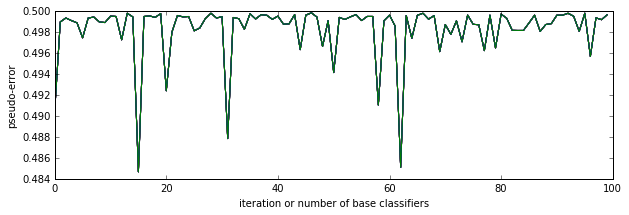

In [190]:
plt.figure(figsize=(10,3));
plt.plot(err_evolution);
plt.xlabel('iteration or number of base classifiers');
plt.ylabel('pseudo-error');

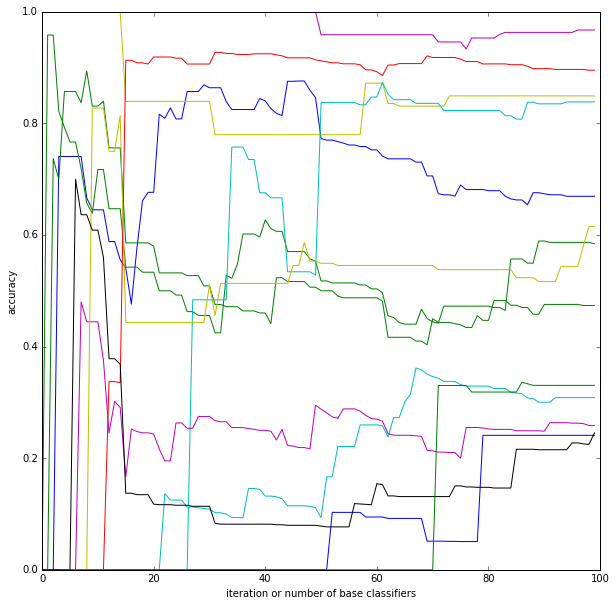

In [192]:
plt.figure(figsize=(10,10));
plt.plot(acc_per_class_evolution, label='train per class');
plt.xlabel('iteration or number of base classifiers');
plt.ylabel('accuracy');

final training accuracy 0.206954102921
final test accuracy 0.114888977002
final train abstained 0.653222067687
final test abstained 0.751090404441


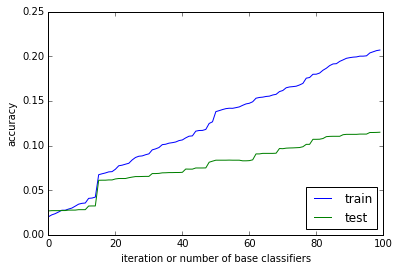

In [191]:
plt.plot(train_accuracy_evolution, label='train');
# plt.plot(range(0, n_iter, 50), test_accuracy_evolution[::50], label='test');
plt.plot(test_accuracy_evolution, label='test');
plt.xlabel('iteration or number of base classifiers');
plt.ylabel('accuracy');
plt.legend(loc='lower right');

print 'final training accuracy', train_accuracy_evolution[-1]
print 'final test accuracy', test_accuracy_evolution[-1]

print 'final train abstained', len(abstained_indices_train)/float(n_train)
print 'final test abstained', len(abstained_indices_test)/float(n_test)

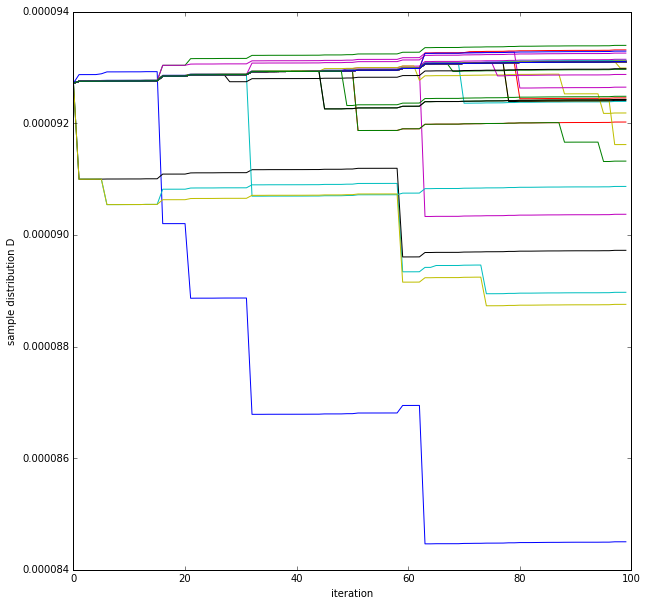

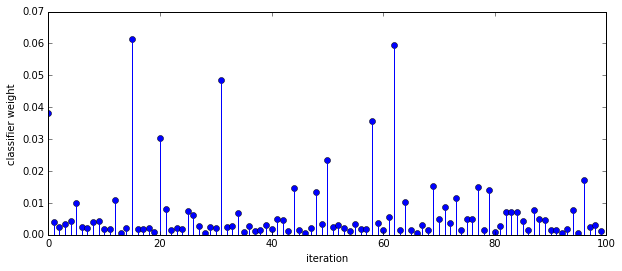

In [193]:
plt.figure(figsize=(10,10));
plt.plot(D_evolution[:, :100]);
plt.xlabel('iteration');
plt.ylabel('sample distribution D');
plt.show();

plt.figure(figsize=(10,4));
plt.stem(weak_clf_weights);
plt.xlabel('iteration');
plt.ylabel('classifier weight');
plt.show();

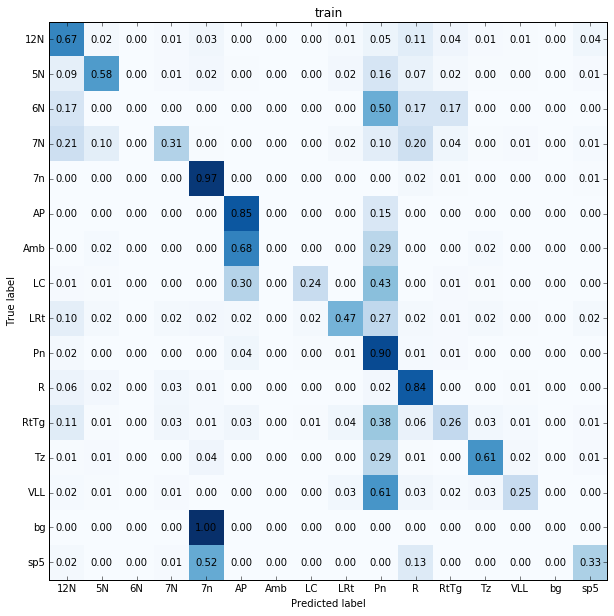

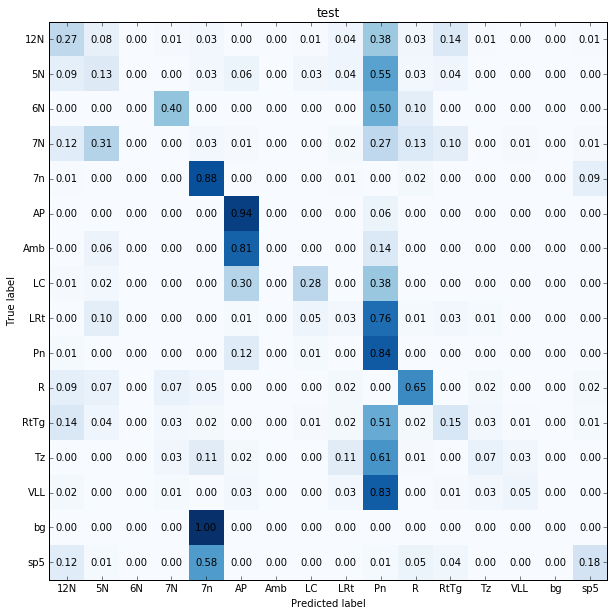

In [194]:
M_train = compute_confusion_matrix(strong_preds_train, train_labels_clf)
plot_confusion_matrix(M_train, labels=[label_to_name[clf_to_label[i]] for i in range(n_classes)], title='train', figsize=(10,10))

M_test = compute_confusion_matrix(strong_preds_test, test_labels_clf)
plot_confusion_matrix(M_test, labels=[label_to_name[clf_to_label[i]] for i in range(n_classes)], title='test', figsize=(10,10))

In [47]:
train_patches = extract_patches_given_addresses(train_addresses)
train_patches = np.array(train_patches)
# bp.pack_ndarray_file(train_patches, sift_dir + '/train/train_patches.bp')

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2224: DecompressionBombWarning: Image size (187528192 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [ ]:
test_patches = extract_patches_given_addresses(test_addresses)
test_patches = np.array(test_patches)
bp.pack_ndarray_file(np.array(test_patches), sift_dir + '/test/test_patches.bp')

In [ ]:
for tt, (center_index, radius, predictions, _, _) in enumerate(weak_clfs[:10]):
    nearest_neighbor_indices = np.argsort(train_dist_mat[center_index])[::-1][1:10]
    patch_indices = [center_index] + list(nearest_neighbor_indices)
    display_images_in_grids(train_patches[patch_indices], nc=10, 
                            titles=['seed %d' % weak_clfs[tt][0]] + ['' for _ in range(9)])

In [ ]:
patch_indices = [center_index for center_index, radius, predictions, center_label, hist in weak_clfs]
display_images_in_grids(train_patches[patch_indices], nc=10, 
                            titles=['L:%s   A:%.2f \nR:%.4f   P:%s' % \
                                    (label_to_name[clf_to_label[center_label]],
                                    a, radius, ','.join([label_to_name[clf_to_label[l]] for l in np.where(predictions)[0]]))
                                    for (center_index, radius, predictions, center_label, hist), a in zip(weak_clfs, weak_clf_weights)])

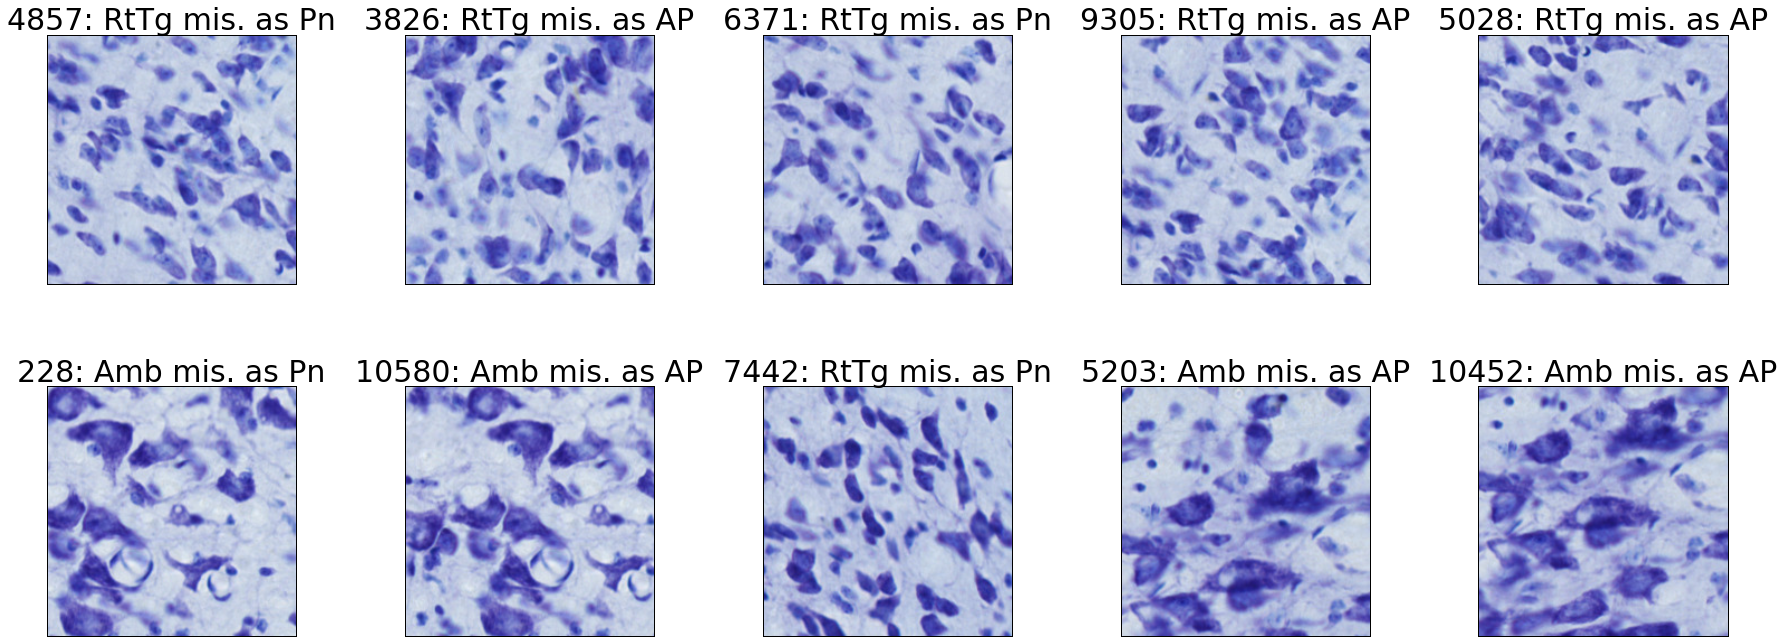

In [106]:
sorted_by_D = np.argsort(D)[::-1]
    
titles = []
for i in sorted_by_D[:10]:
    confusible_label = np.argsort(q[i])[::-1][0]
    titles.append('%d: %s mis. as %s' % \
                  (i, label_to_name[clf_to_label[train_labels_clf[i]]], label_to_name[clf_to_label[confusible_label]]))
    
display_images_in_grids(train_patches[sorted_by_D[:10]], nc=5, titles=titles)

In [84]:
num_examples = np.bincount(train_labels_clf, minlength=len(names0))
# {label_to_name[clf_to_label[l]]: c for l, c in enumerate(np.bincount(train_labels_clf, minlength=len(names0)))}

Dd = np.zeros((n_classes, ))
for u in range(n_classes):
    m = train_labels_clf == u
    Dd[u] = np.sum(D[m]) / num_examples[u]

# plt.figure(figsize=(10,10));
# plt.matshow(Dd, vmin=0.001);
# plt.colorbar();
# plt.show();

# plot_confusion_matrix(Q, labels=[label_to_name[clf_to_label[i]] for i in range(n_classes)], title='Q', figsize=(10,10))

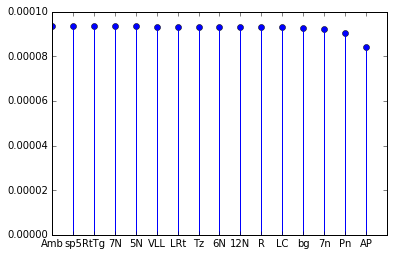

In [85]:
# ranked by D

plt.stem([Dd[i] for i in np.argsort(Dd)[::-1]]);
labels = [label_to_name[clf_to_label[i]] for i in np.argsort(Dd)[::-1]]
plt.xticks(range(n_classes), labels);

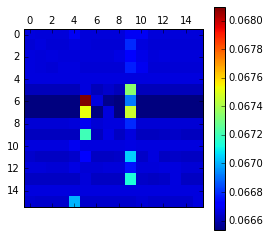

In [100]:
Q = np.zeros((n_classes, n_classes))
for u in range(n_classes):
    m = train_labels_clf == u
#     Q[u] = np.sum(D[m,None]*q[m], axis=0)
    Q[u] = np.sum(D[m,None]*q[m], axis=0)/D[m].sum()

for u in range(n_classes):
    Q[u,u] = Q[Q!=0].mean()
    
plt.figure(figsize=(10,10));
plt.matshow(Q);
plt.colorbar();
plt.show();

# plot_confusion_matrix(Q, labels=[label_to_name[clf_to_label[i]] for i in range(n_classes)], title='Q', figsize=(10,10))

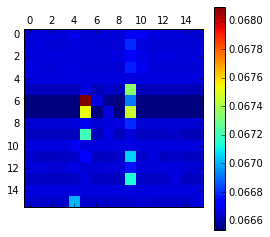

In [105]:
Ww = np.zeros((n_classes, n_classes))
for u in range(n_classes):
    m = train_labels_clf == u
    Ww[u] = np.sum(w[m], axis=0)/w[m].sum()

for u in range(n_classes):
    Ww[u,u] = Ww[Ww!=0].mean()
    
plt.figure(figsize=(10,10));
plt.matshow(Ww);
plt.colorbar();
plt.show();

# plot_confusion_matrix(Q, labels=[label_to_name[clf_to_label[i]] for i in range(n_classes)], title='Q', figsize=(10,10))